In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/soccomp/

/content/drive/MyDrive/soccomp


In [6]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# **Exploratory Data analysis**
1. Basic Analysis
- Number of posts
- Frequency of posts over time
- Average upvotes
- Common keywords

Total Posts: 1045
Average Upvotes: 137.34832535885167


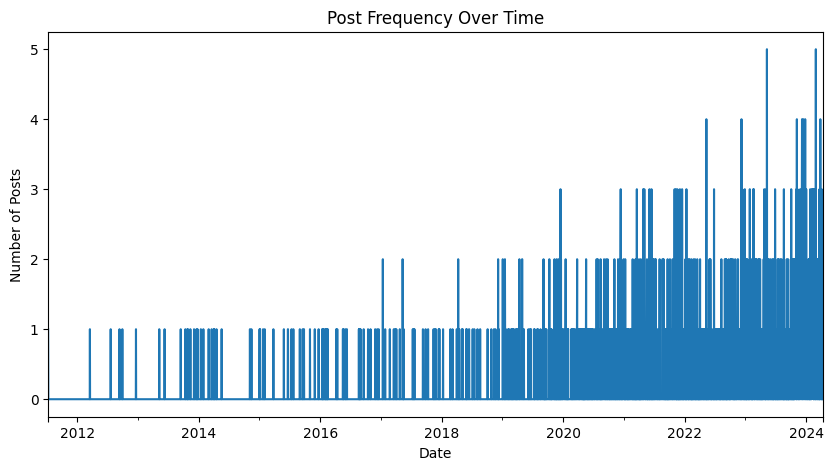

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from collections import Counter
import json
from transformers import pipeline, DistilBertTokenizer


# Load JSON data
with open('data1.json', 'r') as file:
    data = json.load(file)

df = pd.DataFrame(data)

df['date'] = pd.to_datetime(df['date'])

# 1. Basic Analysis
print("Total Posts:", df.shape[0])
print("Average Upvotes:", df['upvotes'].mean())

# Frequency of posts over time
df.set_index('date', inplace=True)
post_counts = df.resample('D').size()
plt.figure(figsize=(10, 5))
post_counts.plot(title='Post Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.show()



2. Temporal Analysis

Plot by months of the year




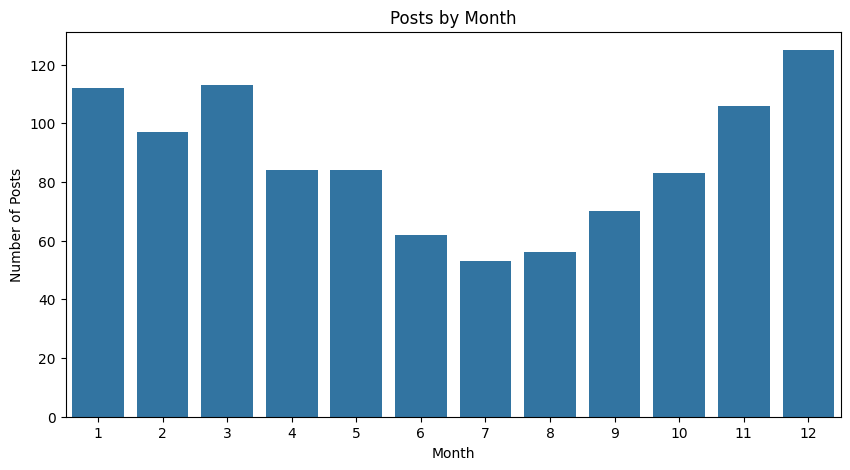

In [17]:
# 2. Temporal Analysis by Month
df['month'] = df.index.month
monthly_posts = df.groupby('month').size()
plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_posts.index, y=monthly_posts.values)
plt.title('Posts by Month')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.show()

3. Sentiment Analysis

 Using NLP tools to analyze the sentiment of posts and gauge the emotional tone

 - stopword removal + vectorization

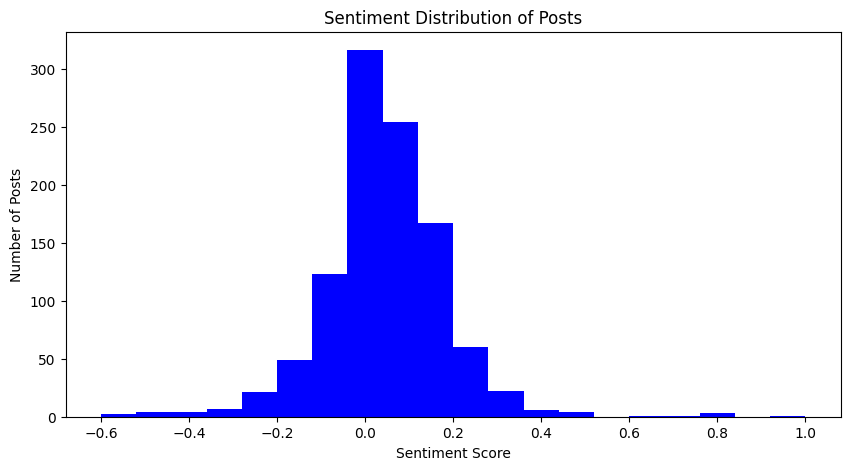

Most Common Keywords: [('time', 1624), ('like', 1312), ('get', 1290), ('work', 1109), ('feel', 771), ('know', 770), ('even', 745), ('would', 745), ('school', 713), ('really', 669)]


In [14]:
# 3. Sentiment Analysis
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return " ".join(filtered_tokens)

df['clean_text'] = df['post'].apply(preprocess_text)
df['sentiment'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10, 5))
plt.hist(df['sentiment'], bins=20, color='blue')
plt.title('Sentiment Distribution of Posts')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Posts')
plt.show()

# Common Keywords
all_words = ' '.join(df['clean_text']).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(10)
print("Most Common Keywords:", common_words)

4. Emotion Analysis

F
ind a library that describes the emotion and use that instead; we want emotions like happy, sad, positive and negative, so that there is a wide range of emotions involved in the post_text


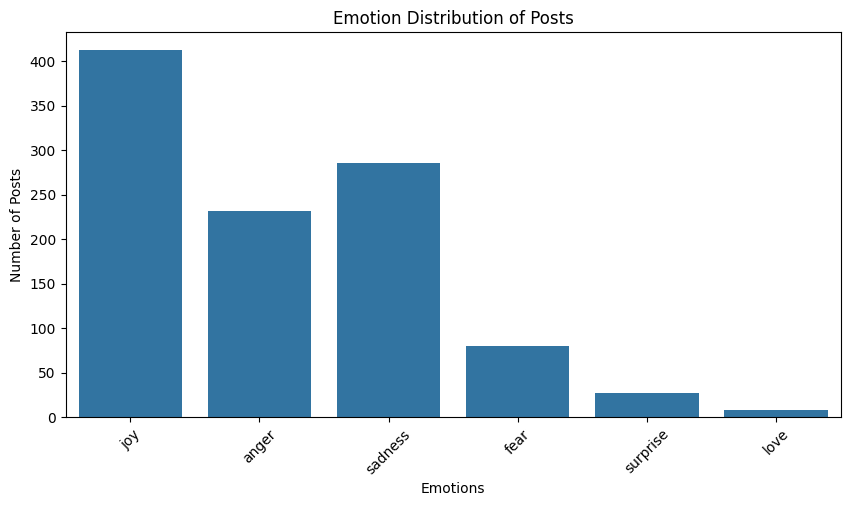

In [29]:
# 4. Emotion Analysis using transformers pipeline
tokenizer = DistilBertTokenizer.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion')
emotion_classifier = pipeline('text-classification', model='bhadresh-savani/distilbert-base-uncased-emotion', tokenizer=tokenizer)

def detect_emotion(text):
    # Truncate the text to the maximum length the model can handle
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    outputs = emotion_classifier.model(**inputs)

    # Decode the model output into readable labels
    logits = outputs.logits
    predictions = logits.argmax(dim=-1)
    labels = [emotion_classifier.model.config.id2label[prediction.item()] for prediction in predictions]

    return labels[0]  # Return the first label (as we're processing single texts)

# Apply the function to the DataFrame
df['emotion'] = df['post'].apply(detect_emotion)

# Plotting Emotion Distribution
plt.figure(figsize=(10, 5))
sns.countplot(x=df['emotion'])
plt.title('Emotion Distribution of Posts')
plt.xlabel('Emotions')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.show()